In [278]:
import numpy as np
import matplotlib.pyplot as plt
from Functions import *
from collections import namedtuple
from scipy.interpolate import CubicSpline

In [279]:
L1      = c/(ng_1550**2 * 20*1e9)
L2      = L1 * 1.005
D1      = c/(ng_1550**2 * L1) *2* np.pi
D2      = c/(ng_1550**2 * L2) *2* np.pi
D_ave   = c/(ng_1550**2 * (L1+L2)/2) *2 *np.pi
# D_ave = D1 * 0.99
epsilon = (L2-L1)/(L1+L2)

FSR = (D1-D2)/(2*epsilon)
M = 1/(2*epsilon)
FSR/1e9/(2*np.pi)
D_ave/(2*np.pi*1e9)

np.float64(19.950124688279306)

Plot coupling under mode number nonconservation

In [280]:
def Load_n(filename):
    info_file_name = "../data/" + filename
    n_list = []
    # dtype = [('modeidx', 'i2'), ('n', str),
    #          ('ng', str), ('loss', 'f8'), ('polarization','f8')]
    # data_read = np.loadtxt(info_file_name, delimiter=',', dtype=dtype,skiprows=1)
    with open(info_file_name,'r') as f:
        data_read = f.readlines()
        for line in data_read[1:]:
            wavl = float(line.split(',')[0].replace(" ","").replace("\n",""))
            n = float(line.split(',')[1].replace(" ","").replace("\n",""))
            n_list.append([wavl,n])
    n_list = np.array(n_list)
    return n_list

In [281]:
def Interpolation(x,y,x_intp,num_of_pts=100):
    cs = CubicSpline(x, y, bc_type='natural')  # bc_type 可选 'natural', 'clamped', 'periodic' 等
    y_intp = cs(x_intp)
    return y_intp

In [282]:
# get_g(m) : dict of coupling strength
def Reson_freq(m,D1,L,epsilon):
    return D1/(2*np.pi)*np.arccos(np.cos(get_g(m)*L)*np.cos(2*np.pi * epsilon *m))

def FSR_func(m,D_ave,L,epsilon):
    return epsilon * D_ave/(2*np.pi)* np.cos(get_g(m)*L)*np.sin(2*np.pi * epsilon *m) /        \
            (1-np.cos(get_g(m)*L)**2 * np.cos(2*np.pi * epsilon *m)**2)**0.5

def Dispersion(m,D_ave,L,epsilon):
    return D_ave *(2*np.pi)* epsilon**2 *np.cos(get_g(m)*L) *np.sin(get_g(m)*L)**2 * np.cos(2*np.pi*epsilon*m) / \
            (1-np.cos(get_g(m)*L)**2 * np.cos(2*np.pi * epsilon *m)**2)**1.5

In [283]:
with open("./results/AD_range_res.txt") as f:
    f.readlines()

In [284]:
num_of_pts  = 5000
Max_M_idx   = 3
m_arr_intp  = np.linspace(-Max_M_idx*M, Max_M_idx*M, num_of_pts)
g_arr_intp  = np.ones(np.shape(m_arr_intp))
def get_g(m,m_arr=m_arr_intp,g_arr=g_arr_intp):
    return g_arr[np.argmin(np.abs(m_arr-m))]

In [285]:
def find_resonance(m,freq_arr,neff_arr,L):
    # freq_arr  unit:THz
    func_arr = freq_arr*1e12 * neff_arr - np.ones(np.shape(freq_arr)) * m * c / L
    # for idx in range(len(freq_arr)-1):
    #     if func_arr[idx] * func_arr[idx+1] < 0:
    #         zero =  freq_arr[idx] + (freq_arr[idx+1]-freq_arr[idx])*\
    #                 np.abs(func_arr[idx])/(np.abs(func_arr[idx])+np.abs(func_arr[idx+1]))
    #         zero_idx = idx
    #         break
    zero_arr,zero_idx_arr = find_zero(freq_arr,func_arr)
    assert len(zero_arr) == 1
    return zero_arr[0],zero_idx_arr[0]

In [286]:
c  = 3*1e8
mm = 1e-3
n  = 1.99

def n_Si3N4(wavl_um):
    return (1+3.0249/(1-(0.1353406/wavl_um)**2)+
            40314/(1-(1239.842/wavl_um)**2))**.5
def n_SiO2(wavl_um):
    return (1+0.6961663/(1-(0.0684043/wavl_um)**2)+
            0.4079426/(1-(0.1162414/wavl_um)**2)+
            0.8974794/(1-(9.896161/wavl_um)**2))**.5


In [287]:
n_eff_arr   = []
n_g_arr     = []
foldername  = "Straight_WG_width_2_8um"
filename = "neff_L_inner_2_8_1500_1600.txt"
neff_arr = Load_n(filename)
filename = "ng_L_inner_2_8_1500_1600.txt"
ng_arr = Load_n(filename)
# wavl_arr    = np.linspace(1480,1620,15)
wavl_arr      = neff_arr[:,0]
wavl_arr_intp = np.linspace(np.min(wavl_arr),np.max(wavl_arr),num_of_pts)
freq_arr      = c/wavl_arr * 1e6/1e12
freq_arr_intp = c/wavl_arr_intp * 1e6/1e12
np.shape(freq_arr_intp)

(5000,)

In [288]:
neff_intp   = Interpolation(wavl_arr, neff_arr[:,1], wavl_arr_intp, num_of_pts=num_of_pts)
ng_intp     = Interpolation(wavl_arr, ng_arr[:,1], wavl_arr_intp, num_of_pts=num_of_pts)
# neff_intp   = Interpolation(freq_arr, neff_arr[:,1], freq_arr_intp, num_of_pts=num_of_pts)
# ng_intp     = Interpolation(freq_arr, ng_arr[:,1], freq_arr_intp, num_of_pts=num_of_pts)
ng_1550     = ng_intp[np.argmin(np.abs(wavl_arr_intp-1.55))]
neff_1550     = neff_intp[np.argmin(np.abs(wavl_arr_intp-1.55))]
neff_1550

np.float64(1.475776379263553)

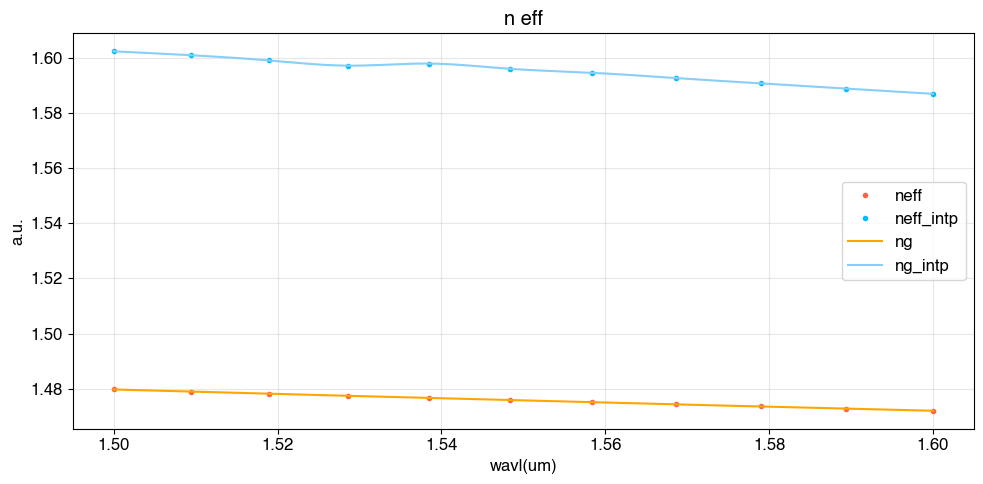

In [289]:
data_arr =  (   np.c_[wavl_arr, neff_arr[:,1], ng_arr[:,1]],
                np.c_[wavl_arr_intp, neff_intp, ng_intp],)
Plot_curve(data_arr,Y_legends=["neff","neff_intp","ng","ng_intp"],
                X_label="wavl(um)",Y_label="a.u.",
                xticks =[], xtickslabel=[],
                title = "n eff",
                marker_list=[".",".","",""]*2,linestyle_list=["","","-","-"]*2,
                colors_list=['tomato','deepskyblue','orange','lightskyblue']*2,
                ylim = -1,dpi=400)


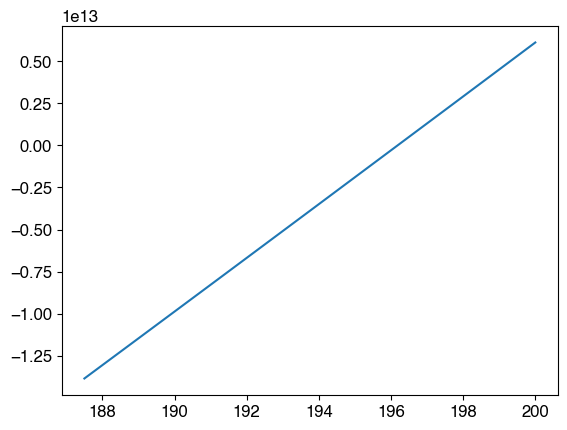

In [290]:
m = 5692
plt.plot(freq_arr, freq_arr*1e12 * neff_arr[:,1] - np.ones(np.shape(freq_arr)) * m * c / L1)

In [291]:
# m0 = 5592
# m_range = 120
# filename_resonance = "./results/resonance.txt"
# with open(filename_resonance,'w') as f:
#     f.write("ModeNum,Fre(THz)\n")
#     for m in range(m0-m_range,m0+m_range):
#         reson_freq,idx = find_resonance(m,freq_arr_intp,neff_intp,L1)
#         f.write("{:.0f}".format(m)+ ",{:.6f}\n".format(reson_freq))

In [292]:
# data_arr = []
# with open(filename_resonance,'r') as f:
#     lines = f.readlines()
#     for line in lines[1:]:
#         line_strip = line.strip()
#         m = int(line_strip.split(",")[0])
#         reson_freq = float(line_strip.split(",")[1])
#         data_arr.append([m,reson_freq])
# data_arr = (np.array(data_arr),)
# Plot_curve(data_arr,Y_legends=["freq"],
#                 X_label="mode number",Y_label="frequency(THz)",
#                 xticks = [], xtickslabel=[],
#                 title="Resonant frequency",
#                 marker_list=[".",".","",""]*2,linestyle_list=["","","-","-"]*2,
#                 colors_list=['tomato','deepskyblue','orange','lightskyblue']*2,
#                 ylim = -1,dpi=400)

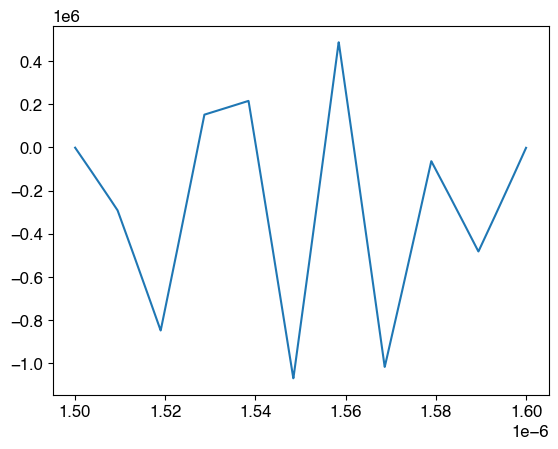

In [293]:
wavl_arr_intp_m =  wavl_arr_intp * 1e-6
Beta_1_intp = First_derivative_central_diff(neff_intp, wavl_arr_intp_m)
Beta_2_intp = wavl_arr_intp_m[2:-2]**3 / (2*np.pi*c**2) * First_derivative_central_diff(Beta_1_intp,
                                                                                wavl_arr_intp_m[1:-1])
D_2         = -c*D_ave**2 * Beta_2_intp / ng_intp[2:-2]
plt.plot(wavl_arr_intp_m[2:-2],D_2/(2*np.pi))

In [294]:
def Mode_nonconserved_coupling(Max_M_idx,M,
                               plot_coupled_curves=True,
                               coupled_data_arr=[],coupled_data_label_arr=[],
                               num_of_pts=100,ylim=20):
    m_arr = np.linspace(-Max_M_idx*M, Max_M_idx*M, num_of_pts).reshape(-1,1)
    M0 = 0
    Y_legends = []
    Y_data = np.array(D1 * (m_arr - M0))
    Y_legends.append(r"Resonator1 $\omega = \omega_0$+$(D_1-D_{ave})$(m-$M_0$)")
    for m in range(1,Max_M_idx):
        Y = D1 * (m_arr - M0) + m*FSR
        Y_data = np.c_[Y_data,Y]
        Y_legends.append(r"Resonator1 $\omega$ = $\omega_0$+$(D_1-D_{ave})$(m-$M_0$)$\pm$"+str(m)+r"$D_{ave}$")
        Y = D1 * (m_arr - M0) - m*FSR
        Y_data = np.c_[Y_data,Y]
        Y_legends.append("")

    Y = D2 * (m_arr - M0)
    Y_data = np.c_[Y_data,Y]
    Y_legends.append(r"Resonator2 $\omega = \omega_0$+$(D_2-D_{ave})$(m-$M_0$)")
    for m in range(1,Max_M_idx):
        Y = D2 * (m_arr - M0) +  m*FSR
        Y_data = np.c_[Y_data,Y]
        Y_legends.append(r"Resonator2 $\omega$ = $\omega_0$+$(D_2-D_{ave})$(m-$M_0$)$\pm$"+str(m)+r"$D_{ave}$")
        Y = D2 * (m_arr - M0) -  m*FSR
        Y_data = np.c_[Y_data,Y]
        Y_legends.append("")
    Y_data = Y_data - D_ave * (m_arr - M0)

    if plot_coupled_curves:
        Y_legends = Y_legends + coupled_data_label_arr
        Y_data = np.c_[Y_data,coupled_data_arr]

    xticks       = np.arange(-Max_M_idx,Max_M_idx+1)
    xtickslabels = [("$M_0$+" if xtick>0 else "$M_0$") + str(xtick) + "M"  for xtick in xticks]
    xtickslabels[int(len(xtickslabels)/2)] = "$M_0$"
    xticks       = np.arange(-Max_M_idx,Max_M_idx+1)*M
    # xtickslabels = np.c_[xtickslabels,""]

    data_arr = (np.c_[m_arr,Y_data/1e9/(2*np.pi)],)
    linestyle_name_list = ["dashed","dotted"]*3
    linestyle_list      = ["-"]
    for i in range(Max_M_idx-1):
        for j in range(2):
            linestyle_list.append(linestyle_name_list[i])
    linestyle_list = linestyle_list + linestyle_list
    linestyle_list = linestyle_list + ["-"]*4
    Plot_curve(data_arr,
                Y_legends=Y_legends,
                X_label='mode number m',Y_label=r"Frequency $\omega$/(2$\pi$) (GHz)",
                xticks=xticks, xtickslabel=xtickslabels,
                title = "Mode number non-conservation coupling",
                marker_list=[""]*15,
                linestyle_list=linestyle_list,
                colors_list = ['tab:blue']*(Max_M_idx*2-1)+
                ['tab:red']*(Max_M_idx*2-1)+['tab:orange']*2+['tab:green']*2+['tab:black']*10,
                ylim = ylim, bbox_to_anchor=(1.05,0.8))


In [295]:
Max_M_idx = 3
num_of_pts  = 1000
m_arr   = np.linspace(-Max_M_idx*M, Max_M_idx*M, num_of_pts)


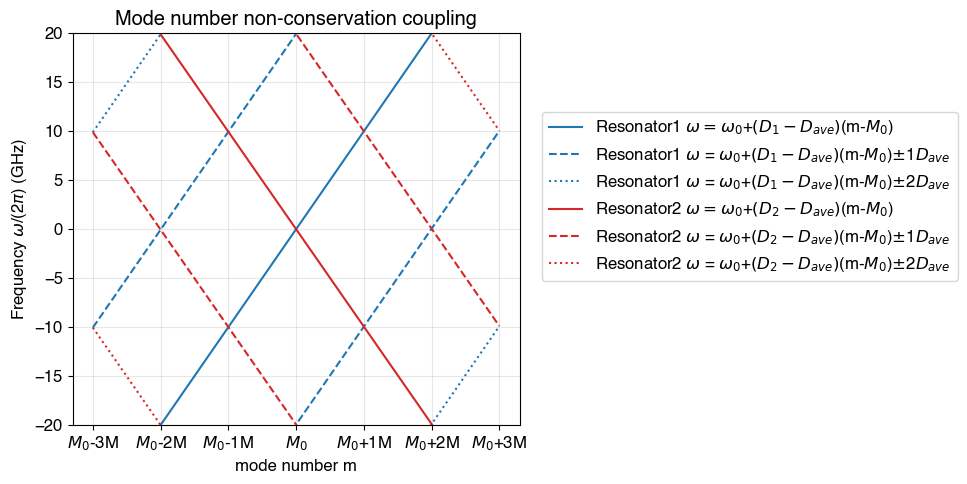

In [296]:
Mode_nonconserved_coupling(Max_M_idx,M,plot_coupled_curves=False,
                           coupled_data_arr=data_arr,
                           coupled_data_label_arr=data_label_arr,
                           num_of_pts=num_of_pts)

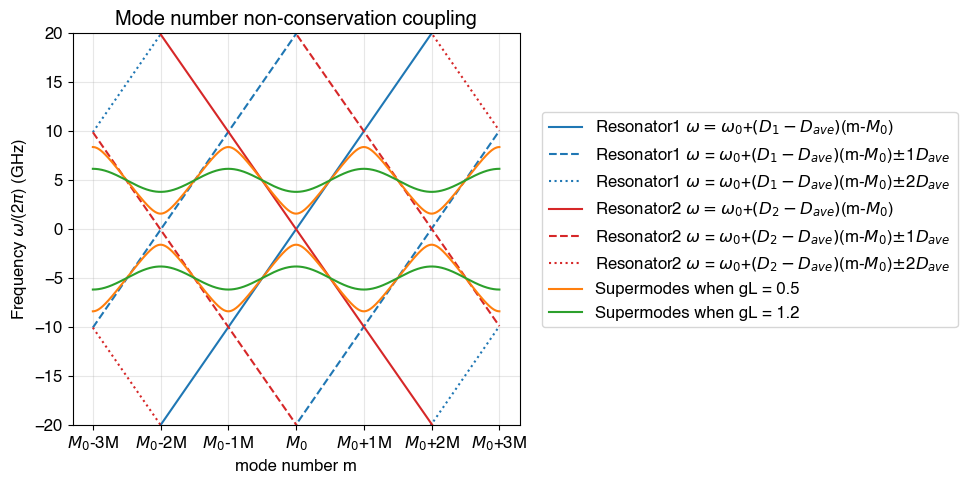

In [297]:
Max_M_idx = 3
m_arr   = np.linspace(-Max_M_idx*M, Max_M_idx*M, num_of_pts).reshape(-1,1)
L1 = 0.5
Y_p_0_3 = Reson_freq(m_arr,D_ave,L1,epsilon)
Y_m_0_3 = -Reson_freq(m_arr,D_ave,L1,epsilon)
L2 = 1.2
Y_p_1   = Reson_freq(m_arr,D_ave,L2,epsilon)
Y_m_1   = -Reson_freq(m_arr,D_ave,L2,epsilon)
data_arr = np.c_[Y_p_0_3,Y_m_0_3,Y_p_1,Y_m_1]
data_label_arr = ["","Supermodes when gL = "+"{:.1f}".format(L1)
                  ,"","Supermodes when gL = "+"{:.1f}".format(L2)]
Mode_nonconserved_coupling(Max_M_idx,M,plot_coupled_curves=True,
                           coupled_data_arr=data_arr,
                           coupled_data_label_arr=data_label_arr,
                           num_of_pts=num_of_pts)


In [298]:
D_iso   = -668                                # unit: ps/nm/km
n_g     = 1.59367
beta_2  = -1550**2/(2*np.pi*c) * D_iso *1e-9  # unit: ps^2/nm
D_2     = -c* (D_ave*1e-12)**2* beta_2 / n_g  # unit: 2pi * GHz
D_2*1e6/(2*np.pi)                             # unit: kHz

np.float64(-400.80459350320683)

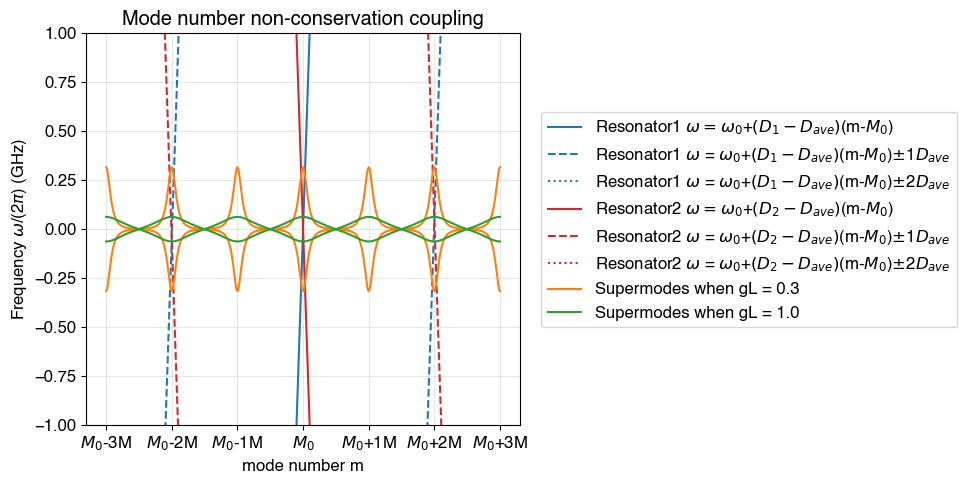

In [299]:
Max_M_idx = 3
m_arr   = np.linspace(-Max_M_idx*M, Max_M_idx*M, num_of_pts).reshape(-1,1)
L1 = 0.3
Y_p_0_3 = D_ave*1e-9 * Dispersion(m_arr,D_ave,L1,epsilon)
Y_m_0_3 = -D_ave*1e-9* Dispersion(m_arr,D_ave,L1,epsilon)
L2 = 1
Y_p_1   = D_ave*1e-9* Dispersion(m_arr,D_ave,L2,epsilon)
Y_m_1   = -D_ave*1e-9* Dispersion(m_arr,D_ave,L2,epsilon)

data_arr = np.c_[Y_p_0_3,Y_m_0_3,Y_p_1,Y_m_1]
data_label_arr = ["","Supermodes when gL = "+"{:.1f}".format(L1)
                  ,"","Supermodes when gL = "+"{:.1f}".format(L2)]
Mode_nonconserved_coupling(Max_M_idx,M,plot_coupled_curves=True,
                           coupled_data_arr=data_arr,
                           coupled_data_label_arr=data_label_arr,
                           num_of_pts=num_of_pts,ylim=1)

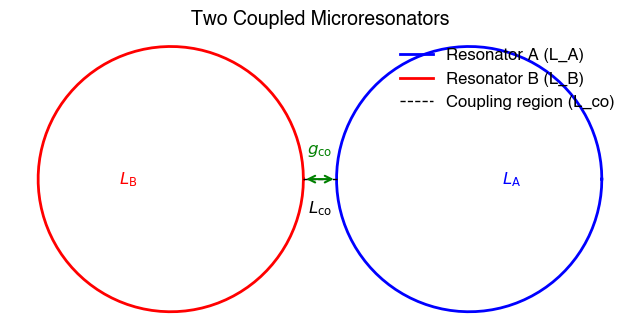

In [300]:
import matplotlib.pyplot as plt
import numpy as np

# 创建画布和坐标轴
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_aspect('equal')
ax.axis('off')  # 隐藏坐标轴

# 定义微环参数
R1, R2 = 2.0, 2.0  # 两个环的半径
d = 0.5             # 耦合区域的间距
L_co = 1.0          # 耦合区域长度（近似）

# 绘制两个微环（跑道形结构）
theta = np.linspace(0, 2*np.pi, 100)

# 环A（右环）
x_A = R1 * np.cos(theta) + R1 + d/2
y_A = R1 * np.sin(theta)
ax.plot(x_A, y_A, color='blue', lw=2, label='Resonator A (L_A)')

# 环B（左环）
x_B = R2 * np.cos(theta) - R2 - d/2
y_B = R2 * np.sin(theta)
ax.plot(x_B, y_B, color='red', lw=2, label='Resonator B (L_B)')

# 绘制耦合区域（用虚线表示）
coupling_x = np.linspace(-d/2, d/2, 50)
coupling_y = np.zeros_like(coupling_x)
ax.plot(coupling_x, coupling_y, '--', color='black', lw=1, label='Coupling region (L_co)')

# 添加标注
ax.annotate('', xy=(d/2, 0), xytext=(-d/2, 0),
            arrowprops=dict(arrowstyle='<->', color='green', lw=1.5))
ax.text(0, 0.3, r'$g_{\mathrm{co}}$', ha='center', va='bottom', fontsize=12, color='green')
ax.text(R1 + d/2 + 0.5, 0, r'$L_{\mathrm{A}}$', ha='left', va='center', fontsize=12, color='blue')
ax.text(-R2 - d/2 - 0.5, 0, r'$L_{\mathrm{B}}$', ha='right', va='center', fontsize=12, color='red')
ax.text(0, -0.3, r'$L_{\mathrm{co}}$', ha='center', va='top', fontsize=12, color='black')

# 添加图例和标题
ax.legend(loc='upper right', frameon=False)
plt.title('Two Coupled Microresonators', fontsize=14)

# 显示图形
plt.show()